In [121]:
using ITensors
using Random
using Plots
using QuadGK
using Roots
using StatsBase

In [146]:
s = siteinds("S=1/2", 25);
mps = randomMPS(ComplexF64, s; linkdims=4);

In [23]:
function get_probability_density(x::Float64, rdm::Matrix)
    """Takes in the 1-site reduced density matrix and 
    returns the probability of a given time series value, x 
    (note, x is before applying encoding, NOT ϕ(x))."""
    # convert time series value to encoded state by applying feature map
    # our complex feature map
    state = [exp(1im * (3π/2) * x) * cospi(0.5 * x), exp(-1im * (3π/2) * x) * sinpi(0.5 * x)]
    return abs(state' * rdm * state) # |<x|ρ|x>|
end

function get_normalisation_constant(rdm::Matrix)
    """Get the normalisation constant Z for the pdf"""
    prob_density_wrapper(x) = get_probability_density(x, rdm)
    norm_const, _ = quadgk(prob_density_wrapper, 0, 1) # integrate over data/x domain
    return norm_const
end

function get_cdf(x::Float64, rdm::Matrix, integral_norm_const::Float64)
    """Get the cumulative distribution function via numerical integration of
    the probability density function.

        Returns cdf evaluated at x where x is the proposed value i.e., F(x)."""

    prob_density_wrapper(x_prime) = (1/integral_norm_const) * get_probability_density(x_prime, rdm)

    cdf_val, _ = quadgk(prob_density_wrapper, 0, x) # pdf has support on the interval [0, 1] so integrate accordingly
    
    return cdf_val
end

function sample_state_from_rdm(rdm)
    """Given a 1 site RDM, samples a random value according to the
    conditional distribution encapsulated by the rdm using inverse transform sampling.
    Returns both the sampled value x (the un-feature mapped value) and the feature mapped
    value ϕ(x)."""
    norm_factor = get_normalisation_constant(rdm)
    u = rand() # sample a uniform random value from ~U(0,1)
    # solve for x by defining an auxilary function g(x) such that g(x) = F(x) - u and then use root finder to solve for x such that g(x) = 0
    cdf_wrapper(x) = get_cdf(x, rdm, norm_factor) - u
    sampled_x = find_zero(cdf_wrapper, (0, 1); rtol=0)
    # map sampled value back to a state
    sampled_state = [exp(1im * (3π/2) * sampled_x) * cospi(0.5 * sampled_x), exp(-1im * (3π/2) * sampled_x) * sinpi(0.5 * sampled_x)]
    
    return sampled_x, sampled_state

end

sample_state_from_rdm (generic function with 1 method)

In [110]:
function interpolate_time_ordered(label_mps::MPS, time_series::Vector{Float64}, interpolate_sites::Vector{Int})
    """Approach 1 - interpolate mps from start to finish, obeying time ordering.
    Takes the full (normalised) time series sample as input, as well as the indices of the sites to interpolate.
    Will treat the interpolation sites as `missing'."""

    # check that the length of the mps equals the sample length
    if length(label_mps) !== length(time_series)
        error("Time series length does not match MPS length.")
    end
    
    # check interpolation idxs exist

    mps = deepcopy(label_mps) # make a copy
    s = siteinds(mps)
    # put the mps into right canonical form - orthogonality center is set to the first site
    orthogonalize!(mps, 1)
    # create storage for samples
    x_samps = Vector{Float64}(undef, length(mps)) 

    # set A to the first MPS site
    A = mps[1]

    # loop through each site and determine whether to project or sample
    for i in eachindex(mps)
        # get the reduced density matrix at site i
        rdm = prime(A, s[i]) * dag(A)
        rdm_m = matrix(rdm) # convert to rdm

        if i in interpolate_sites
            #println("Sampling site $i from the reduced density matrix.")
            # sample a state from the rdm using inverse transform sampling
            sampled_x, sampled_state = sample_state_from_rdm(rdm_m)
            x_samps[i] = sampled_x
            if i != length(mps)
                sampled_state_as_ITensor = ITensor(sampled_state, s[i])
                # get the probability of the state for normalising the next site
                proba_state = get_probability_density(sampled_x, rdm_m)
                #println("Prob of sampled state: $proba_state")
                # check that the trace of the rdm is equal to one
                sampled_x, sampled_state = sample_state_from_rdm(rdm_m)
                # make the measurment of the site
                Am = A * dag(sampled_state_as_ITensor)
                # absorb into the next site
                A_new = mps[(i+1)] * Am
                # normalise by the probability
                A_new *= 1/sqrt(proba_state)
                # set A to A_new
                A = A_new
            end

        else
            # make a projective measurement using known value
            #println("Measuring site $i to be a known value: $(time_series[i]).")
            known_x = time_series[i]
            known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
            known_state_as_ITensor = ITensor(known_state, s[i])
            
            # make the measurment at the site
            Am = A * dag(known_state_as_ITensor)

            # absorb orthogonality center into the next site
            if i != length(mps)
                A_new = mps[(i+1)] * Am
                # normalise by the probability of the known state
                proba_state = get_probability_density(known_x, rdm_m)
                A_new *= 1/sqrt(proba_state)
                A = A_new
            end
            x_samps[i] = known_x
        end
    end

    return x_samps

end

interpolate_time_ordered (generic function with 1 method)

In [147]:
time_series = rand(25) # make a fake time series
interp_idxs = [5, 10, 15, 20]

4-element Vector{Int64}:
  5
 10
 15
 20

In [148]:
samps = Matrix{Float64}(undef, 1000, 25)
for i in 1:1000
    samps[i, :] = interpolate_time_ordered(mps, time_series, interp_idxs)
end

In [149]:
mean_ts = mean(samps, dims=1)
std_ts = std(samps, dims=1)

1×25 Matrix{Float64}:
 2.44371e-15  1.11078e-16  2.33263e-15  …  2.11048e-15  1.11078e-15

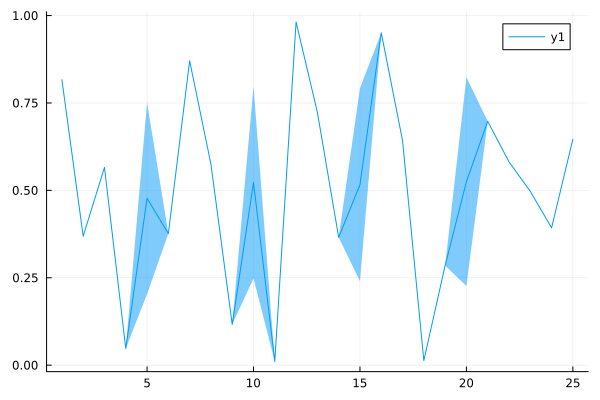

In [150]:
plot(mean_ts[1,:], ribbon=std_ts[1,:])